In [1]:
## Practical quantum mechanics using computers

The standard approach to learning quantum mechanics (QM) involves a fair amount of theory, with some relatively simple pen-and-paper calculations once the theory has been introduced.  But the vast majority of practical QM calculations are done numerically, using a computer.  This series of ipython notebooks is designed to show you how this works, and to give you the ability to do these calculations for yourself.  They should deepen your understanding of how QM works.

In this notebook, we will be setting up some basic python functions to allow you to calculate the energies of arbitrary states in an infinite square well; these functions will then be used when we change the basis set, and change the potential.

The rough flow of all these QM calculations will be:

* Choose and define a basis set
* Define the potential in the well (either as a function or by values on a grid)
* Create the Hamiltonian matrix
* Diagonalise (using libraries) to give eigenvalues and eigenvectors
* Display the results

In general, if we have a basis set $\vert\phi_i\rangle, i=1\rightarrow N$, we write the Hamiltonian matrix element between two basis functions as:

$$
H_{ij} = \langle \phi_i\vert\hat{H}\vert\phi_j\rangle
$$

Typically these matrix elements are found by integration on a grid in real space, though there are many other approaches (and some operators and functions where this is not possible).  Remember that the indices $i$ and $j$ in $H_{ij}$ are *arbitrary*: that is, they can each take on any of the values from $1$ to $N$.

### The eigenbasis

The simplest (but least illustrative !) basis set to use is that of the eigenvectors for the system.  For the square well, these are very simple to deduce (they are identical to the solutions for waves on a classical string fixed at both ends).  If we define the potential to be $V(x) = 0, 0 < x < a; V(x) = \infty, x>a; V(x) = \infty, x<0$, then the eigenvectors are:

$$
\phi_n(x) = A\sin\left(\frac{n\pi x}{a}\right), n=1, 2, 3, \ldots
$$

where $A$ is an appropriate normalisation constant (it's easy to show that the constant is $\sqrt{2/a}$ but we want a general approach to normalisation so we'll add a numerical normalisation routine).  We can create a function to generate a set of eigenvectors in an array in python, and another function to normalise them; we will do this in just a moment.  

However, we must first note an important point: the basis set we have defined here is technically infinite: that is, when we say that $i=1 \rightarrow N$, we have $N=\infty$.  Of course, even with powerful computers, we cannot use an infinite basis set, so we will have to *truncate* the set by choosing a maximum, finite value for $N$ (and note that this will mean that our calculations will be approximations, though we can improve the approximation by increasing the value we have chosen for $N$).

In the next cell we will write a function `square_well_eigenfunctions` which will create the general eigenstate $\phi_{n}(x)$. For completeness (and as a check) we'll then plot some of these.  We also create a function to return the second derivatives (for the kinetic energy), `second_derivative_square_well_eigenfunctions`, and an integration routine that we can use for normalisation, `integrate_functions`.  (In this case, we can write the second derivatives rather easily; we will see a numerical approach to differentiation in another notebook.)

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(0, 11)

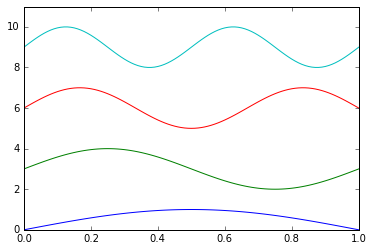

In [2]:
# Import libraries and set up in-line plotting.
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np

# Define the eigenbasis - normalisation needed elsewhere
def square_well_eigenfunctions(n,width,norm,x):
    """The eigenbasis for a square well, running from 0 to a (width), sin(n pi x/a). 
    N.B. requires a normalisation factor, norm."""
    wavevector = np.pi*n/width
    return norm*np.sin(wavevector*x)

# We will also define the second derivative for kinetic energy (KE)
def second_derivative_square_well_eigenfunctions(n,width,norm,x):
    """The second derivative of the eigenbasis for a square well, running from 0 to a, sin(n pi x/a)"""
    wavevector = np.pi*n/width
    return -wavevector*wavevector*norm*np.sin(wavevector*x)

# Define the x-axis
square_well_width = 1.0
number_of_x_points = 101
x = np.linspace(0.0,square_well_width,number_of_x_points)
x_spacing = square_well_width/(number_of_x_points - 1)

# Integrate two functions over the width of the well
# NB this is a VERY simple integration routine: there are much better ways
def integrate_functions(function1,function2,number_of_points,dx):
    """Integrate the product of two functions over defined x range with spacing dx"""
    integral = 0.0
    for i in range(number_of_points):
        integral = integral + function1[i]*function2[i]
    integral = integral*dx
    return integral


# Now plot the first few functions; we offset them vertically by adding 3(n-1) 
# to make it clearer; remember that range(1,5) will give number 1 to 4. We don't
# normalise in this plot.
for m in range(1,5):
    pl.plot(x,square_well_eigenfunctions(m,square_well_width,1.0,x)+3*(m-1))
# Set y-axis so that we can see all the functions
pl.ylim((0,11))

Do these make sense ? You should ask yourself if they match the boundary conditions, and if they fit with your expectations of the physical properties of the system.

We should now be confident that our function is correct (it's always worth checking this somehow, whether through plotting the output or a simple test).  So we will create arrays to store the first ten basis states, properly normalised.  I have chosen ten for no particular reason - we could use fewer or more states.

In [3]:
# These arrays will each hold an array of functions
basis_functions = []
second_derivative_basis_functions = []

number_of_basis_functions = 10
# Loop over first num_basis basis states, normalise and create an array
# NB the basis_array will start from 0
for n in range(1,number_of_basis_functions+1):
    # Calculate A = <phi_n|phi_n>
    eigenfunction_n_unnormalised = square_well_eigenfunctions(n,square_well_width,1.0,x)
    integral = integrate_functions(eigenfunction_n_unnormalised,eigenfunction_n_unnormalised,number_of_x_points,x_spacing)
    # Use 1/sqrt{A} as normalisation constant
    normalisation = 1.0/np.sqrt(integral)
    basis_functions.append(square_well_eigenfunctions(n,square_well_width,normalisation,x))
    second_derivative_basis_functions.append(second_derivative_square_well_eigenfunctions(n,square_well_width,normalisation,x))
    

Notice how we have done the numerical integration: it is a *very* simple integration scheme (there are far better ones available) which is almost an implementation of the trapezium rule.  How do we calculate the integral with the Hamiltonian ? In this case we can construct the kinetic energy explicitly, and the potential can be specified by its value on the grid.  If we do not have the second derivatives analytically, or do not want to code them, we might also use a numerical approach to differentiate (finite differences).

We know that the energies for the eigenvectors are given by $E_{n} = \hbar^{2} k_{n}^{2}/(2m) = \hbar^{2} n^{2} \pi^{2}/(2m a^{2})$ , for a well with width $a$.  We can check this easily in our code:

* Calculate $\langle \phi_{n} \vert \hat{H} \vert \phi_{n} \rangle$ where $\hat{H} = -\frac{\hbar^{2}}{2m} \frac{d^{2}}{dx^{2}}$ in position representation
* For simplicity, we'll set $\hbar = m = 1$ (atomic units) but we will define the constants in the code
* We'll calculate this and check it against the analytical result

In [4]:
# Define constants - here I use atomic units
hbar = 1.0
hbar_squared = hbar**2
m_e = 1.0 # Mass of the electron
two_m_e = 2.0*m_e
# These are not needed but are easier
pi_squared = np.pi**2
square_well_width_squared = square_well_width**2

energy = np.zeros(number_of_basis_functions)
for m in range(number_of_basis_functions):
    #range starts from 0 not 1 so need to add one to get n.
    n = m+1
    H_acting_on_phi = -(hbar_squared/two_m_e)*second_derivative_basis_functions[m]
    energy[m] = integrate_functions(basis_functions[m],H_acting_on_phi,number_of_x_points,x_spacing)
    print "Energy calculated for eigenstate n=",n," is ",energy[m]
    print "Energy expected   for eigenstate n=",n," is ",hbar_squared*n*n*pi_squared/(two_m_e*square_well_width_squared)

Energy calculated for eigenstate n= 1  is  4.93480220054
Energy expected   for eigenstate n= 1  is  4.93480220054
Energy calculated for eigenstate n= 2  is  19.7392088022
Energy expected   for eigenstate n= 2  is  19.7392088022
Energy calculated for eigenstate n= 3  is  44.4132198049
Energy expected   for eigenstate n= 3  is  44.4132198049
Energy calculated for eigenstate n= 4  is  78.9568352087
Energy expected   for eigenstate n= 4  is  78.9568352087
Energy calculated for eigenstate n= 5  is  123.370055014
Energy expected   for eigenstate n= 5  is  123.370055014
Energy calculated for eigenstate n= 6  is  177.65287922
Energy expected   for eigenstate n= 6  is  177.65287922
Energy calculated for eigenstate n= 7  is  241.805307827
Energy expected   for eigenstate n= 7  is  241.805307827
Energy calculated for eigenstate n= 8  is  315.827340835
Energy expected   for eigenstate n= 8  is  315.827340835
Energy calculated for eigenstate n= 9  is  399.718978244
Energy expected   for eigenstate 

These numbers agree extremely well! We would find worse agreement if we used fewer points in our x array (you might like to try this).

### Matrix representation

What about the rest of the Hamiltonian matrix, i.e. the numbers $\langle \phi_n \vert \hat{H} \vert \phi_m \rangle$ ? We'll calculate these using two loops, and output the results.  I will use two approaches: a formatted print written in the loop, and the internal numpy printing for arrays (though this requires some changes to the options to make it look nice).

In [5]:
# Create a square array to store the matrix elements
H_matrix = np.eye(number_of_basis_functions)

print "Output of the Hamiltonian matrix elements as we calculate them"
# Loop over basis functions phi_n (the ket in the matrix element)
for n in range(number_of_basis_functions):
    # Act with H on phi_n and store in H_acting_on_phi_n
    # This is another ket
    H_acting_on_phi_n = -(hbar_squared/two_m_e)*second_derivative_basis_functions[n]
    # Loop over basis functions phi_m (the bra in the matrix element)
    for m in range(number_of_basis_functions):
        # Create matrix element by integrating
        H_matrix_element_mn = integrate_functions(basis_functions[m],H_acting_on_phi_n,number_of_x_points,x_spacing)
        H_matrix[m,n] = H_matrix_element_mn
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_matrix_element_mn,
    # This print puts in a new line when we have finished looping over m
    print

print
print "Now the numpy output with formatting"
print
# Another way to output is this, though it's commented out to avoid clutter
np.set_printoptions(precision=3,linewidth=100,suppress=True)    
print H_matrix

Output of the Hamiltonian matrix elements as we calculate them
   4.935   -0.000    0.000   -0.000    0.000    0.000    0.000   -0.000    0.000   -0.000
  -0.000   19.739   -0.000   -0.000    0.000   -0.000    0.000   -0.000   -0.000   -0.000
   0.000    0.000   44.413    0.000   -0.000    0.000   -0.000   -0.000    0.000    0.000
  -0.000   -0.000    0.000   78.957    0.000   -0.000   -0.000   -0.000   -0.000   -0.000
  -0.000   -0.000    0.000   -0.000  123.370    0.000    0.000    0.000   -0.000   -0.000
   0.000    0.000    0.000    0.000    0.000  177.653   -0.000   -0.000    0.000    0.000
   0.000    0.000   -0.000   -0.000    0.000    0.000  241.805   -0.000    0.000   -0.000
  -0.000    0.000   -0.000    0.000    0.000   -0.000   -0.000  315.827   -0.000    0.000
   0.000   -0.000    0.000   -0.000   -0.000    0.000    0.000   -0.000  399.719    0.000
  -0.000   -0.000    0.000   -0.000   -0.000    0.000   -0.000    0.000    0.000  493.480

Now the numpy output with formatting

It should not surprise you that the matrix is diagonal: because the basis vectors are eigenvectors, an operator acts on a basis vector and returns that basis vector multiplied by the relevant eigenvalue.  The orthogonality of the basis then ensures that only the diagonal elements are non-zero.

Of course, we can choose other basis vectors than the eigenvectors.  In these cases, the matrix will *not* be diagonal.  We will look at this in a subsequent notebook.

Once we have the Hamiltonian (or any observable matrix) we can find the eigenvalues and eigenvectors from the matrix.  There are many approaches to this, but we will rely on the built-in `numpy` routines in `numpy.linalg`: `eigh` for a Hermitian matrix (or just `eig` for a non-Hermitian matrix).

### Overall procedure

In general, when using the matrix approach to quantum mechanics, we will follow this pattern:

* Choose a basis for the problem, ${\vert\phi_{m}\rangle}$
* Create the Hamiltonian matrix, $\langle \phi_{m} \vert \hat{H} \vert \phi_{n} \rangle$
* Find the eigenvalues and eigenvectors of the Hamiltonian
* Or just evaluate the energy of a particular state, $\vert \psi \rangle$

There are many numerical libraries which allow you to solve for the eigenvalues and eigenvectors of a matrix.  We will introduce the `numpy` version of these, and show some examples, in the next notebook.

### A general state

It is helpful to remember that we can also explore what happens to a general state, written as:

$$\vert \psi \rangle = \sum_n c_n \vert \phi_n \rangle$$

We define an array of coefficients, and then build $\vert\psi\rangle$ and its second derivative, and evaluate the energy in two ways: first, directly, as the expectation value of the Hamiltonian operator in this state ($\langle \psi \vert \hat{H} \vert \psi \rangle$); second, by summing over the eigenvalues, weighted by the square modulus of the coefficients ($E = \sum_n \vert c_n \vert^2 E_n$).  Of course, these two should be exactly the same.

Energy numerically is:  43.5907527715
Energy analytically is:  43.5907527715


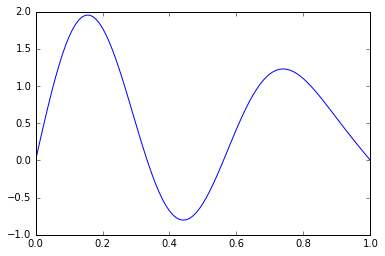

In [6]:
# Define an array to hold the coefficients of our state
coefficient_array = np.zeros(number_of_basis_functions)
coefficient_array[0] = 1.0
coefficient_array[2] = 2.0
coefficient_array[3] = 1.0
# Prepare to make psi and its second derivative
psi = np.zeros(number_of_x_points)
second_derivative_psi = np.zeros(number_of_x_points)
for i in range(number_of_basis_functions):
    psi = psi+coefficient_array[i]*basis_functions[i]
    second_derivative_psi = second_derivative_psi+coefficient_array[i]*second_derivative_basis_functions[i]
# Now we will normalise psi and apply the same factor to d2psi
integral = integrate_functions(psi,psi,number_of_x_points,x_spacing)
psi = psi/np.sqrt(integral)
second_derivative_psi = second_derivative_psi/np.sqrt(integral)
# Also apply the normalisation to the coefficient array
# We could also have normalised psi by ensuring that the square modulus of the
# coefficient array was one
coefficient_array = coefficient_array/np.sqrt(integral)
# Plot psi
pl.plot(x,psi)
# Evaluate the energy from <psi|H|psi> - with no potential we just have
# the kinetic energy term.  Find the expectation value explicitly
H_acting_on_psi = -(hbar_squared/two_m_e)*second_derivative_psi
print "Energy numerically is: ",integrate_functions(psi,H_acting_on_psi,number_of_x_points,x_spacing)
# Find the expectation value of the Hamiltonian (the energy) 
# by summing over energies weighted by the square modulus of the coefficients
energy_psi = 0.0
for i in range(number_of_basis_functions):
    energy_psi = energy_psi + coefficient_array[i]*coefficient_array[i]*energy[i]
print "Energy analytically is: ",energy_psi

Again, we see that the energies agree perfectly.  Notice that the numerical approach, of evaluating the expectation value of the Hamiltonian through integration on a grid, is completely general, and can be extended to situations where the potential changes (though in that case we will need to look at how many basis functions we should include).